In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from PIL import Image, ImageGrab, ImageTk, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os

print(torch.__version__)

2.1.1


In [3]:
# Custom Paired Dataset Class

class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, lowres_folder, highres_folder, transform=None):
        self.lowres_folder = lowres_folder
        self.highres_folder = highres_folder
        self.transform = transform
        # Assuming file names in both folders are the same and in order.
        self.filenames = [f for f in os.listdir(lowres_folder) if os.path.isfile(os.path.join(lowres_folder, f))]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        lowres_path = os.path.join(self.lowres_folder, self.filenames[idx])
        highres_path = os.path.join(self.highres_folder, self.filenames[idx])

        lowres_image = Image.open(lowres_path).convert('RGB')
        highres_image = Image.open(highres_path).convert('RGB')

        if self.transform is not None:
            lowres_image = self.transform(lowres_image)
            highres_image = self.transform(highres_image)

        return lowres_image, highres_image

### Loading the Data

In [5]:
# Transform into tensors

transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor(),
])

data_path = "data_final/"
dataset = PairedDataset(lowres_folder= f"{data_path}/lowres", highres_folder=f"{data_path}/highres", transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size= 32, shuffle = True)

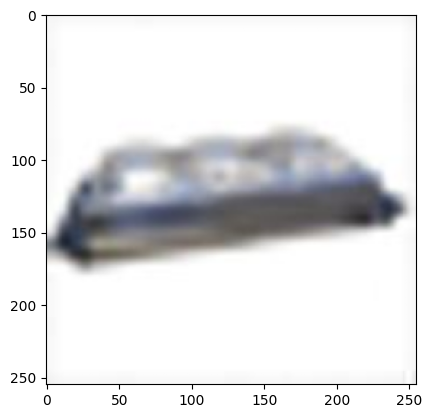

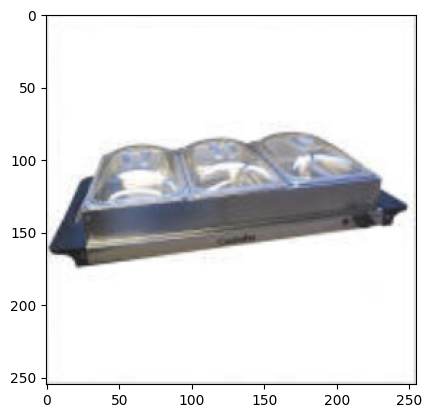

In [14]:
# Make sure images are correct
def imshow(img_tensor):
    # Convert from tensor to numpy array
    np_img = img_tensor.numpy()
    # Change from (C, H, W) to (H, W, C) for visualization
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Get a batch of images and labels
data_iter = iter(data_loader)
paired_images = next(data_iter)

lowres_images, highres_images = paired_images

# Visualize images in the batch
imshow(lowres_images[0])  # Low-res image
imshow(highres_images[0])  # High-res image

In [20]:
# Split the dataset into train and validation
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

print(f"Total Images: {2 * len(dataset)}")
print(f"Training Images: {2 * len(train_dataset)}")
print(f"Validation Images: {2 * len(valid_dataset)}")


Total Images: 2274
Training Images: 1818
Validation Images: 456


## SRCNN

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
# SRCNN

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)  # Patch extraction
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)  # Non-linear mapping
        self.layer3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)   # Reconstruction

    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        x = self.layer3(x)
        return x

model = SRCNN()


### Loss Function and Optimizer

In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

### Train the Model

In [ ]:
epochs = 1

for epoch in range(epochs):
    model.train()
    counter = 0
    for paired_images in data_loader:
        counter += 1
        print(counter)
        lowres_image, highres_image = paired_images
        lowres_image = lowres_image[0]
        highres_image = highres_image[0]

        optimizer.zero_grad()
        output = model(lowres_images)

        loss = criterion(output, highres_image)
        loss.backward()
        optimizer.step()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

## SRGAN

In [87]:
class RRDB(nn.Module):
    def __init__(self, channels = 64, growth_rate = 32):
        super(RRDB, self).__init__()
        self.layer1 = nn.Conv2d(channels, growth_rate, kernel_size= 3, padding=1)
        self.layer2 = nn.Conv2d(channels + growth_rate, growth_rate, kernel_size=3, padding=1)
        self.layer3 = nn.Conv2d(channels + 2 * growth_rate, growth_rate, kernel_size=3, padding=1)
        self.layer4 = nn.Conv2d(channels + 3 * growth_rate, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        residual = x

        out = nn.functional.relu(self.layer1(x))
        out = nn.functional.relu(self.layer2(torch.cat([out, x], 1)))
        out = nn.functional.relu(self.layer3(torch.cat([out, x], 1)))
        out = self.layer4(torch.cat([out, x], 1))

        return residual + out

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.initial_layer = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        self.rrdb1 = RRDB()
        self.rrdb2 = RRDB()
        self.rrdb3 = RRDB()

        self.final_layer = nn.Conv2d(64, 3, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = nn.functional.relu(self.initial_layer(x))

        x = self.rrdb1(x)
        x = self.rrdb2(x)
        x = self.rrdb3(x)

        x = self.final_layer(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def discriminator_block(in_channels, out_channels, normalization=True):
            layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
            if normalization:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(3, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.AdaptiveAvgPool2d(1)
        )

        self.final_shit = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        out = self.model(img)
        out = self.final_shit(out)
        return out.squeeze()

generator = Generator()
discriminator = Discriminator()

### Loss Functions & Optimizers

In [88]:
criterion = torch.nn.MSELoss()
adversarial_loss = torch.nn.BCELoss()

optimizer_g = torch.optim.AdamW(generator.parameters(), lr = 0.001)
optimizer_d = torch.optim.AdamW(discriminator.parameters(), lr = 0.001)


### Train the Model

In [89]:
epochs = 1

for epoch in range(epochs):
    for paired_images in data_loader:

        lowres_image, highres_image = paired_images

        optimizer_d.zero_grad()
        
        batch_size = highres_image.size(0)
        real_labels = torch.ones(batch_size)
        fake_labels = torch.zeros(batch_size)

        highres_output = discriminator(highres_image).squeeze()
        adv_loss_highres = adversarial_loss(highres_output, real_labels)

        predicted_highres_imgs = generator(lowres_image)
        predicted_output = discriminator(predicted_highres_imgs).squeeze()
        adv_loss_pred = adversarial_loss(predicted_output, fake_labels)

        d_loss = (adv_loss_highres + adv_loss_pred) / 2
        d_loss.backward()
        optimizer_d.step()

        optimizer_g.zero_grad()
        pred_output = discriminator(predicted_highres_imgs)
        g_adv_loss = adversarial_loss(pred_output, real_labels)

        g_MSEloss = criterion(predicted_highres_imgs, highres_image)
        g_loss = g_MSEloss + 0.001 * g_adv_loss
        g_loss.backward()
        optimizer_g.step()
    
    print(f"Epoch [{epoch + 1}/{epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")




RuntimeError: Given groups=1, weight of size [32, 128, 3, 3], expected input[32, 96, 255, 255] to have 128 channels, but got 96 channels instead